In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
import numpy as np

2024-02-19 10:40:01.485373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 10:40:01.485436: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 10:40:01.486522: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 10:40:01.575605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## construct a simple dataset for a simple problem

We will fit a sinusoid from a limited number of samples.

The nature of this problem is perfect for this course: we want to accompany predictions with a level of uncertainty. The uncertainty should be low as we get close to the training points, high otherwise.

We create two linear sequences of 15 points with a "hole" in the middle. This will serve as a training data for our machine learning model.

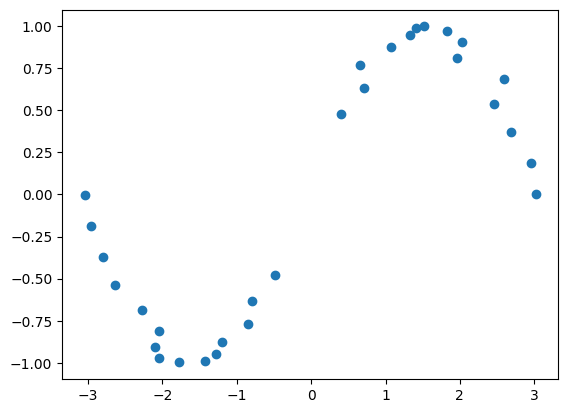

In [3]:
x_max = 3.14
x_min_pos = 0.5
n = 30
assert n//2 != 0, f"Only even number of data allowed (current {n})"

x = np.concatenate([np.linspace(-x_max, -x_min_pos, num=n//2), np.linspace(x_min_pos, x_max, num=n//2)])
y = np.sin(x)
x += np.random.normal(0, 0.1, x.shape)



# plot the data
plt.scatter(x, y)

This dataset could be fit pretty easily by a plethora of very simple machine learning models; however, in this course we are mainly focused on neural networks (NNs).

Specifically, we will quickly review how to train a very small NN using Keras as a refresher of this library.

### Detour on tensors

Tensorflow (and PyTorch) revolve around the concept of tensor.
For our purposes, we can view the tensor as an extension of the concept of vector and matrix into $n$ dimensions.

A vector of size $k_1$ can be seen as an ordered collection of $k_1$ scalars. We represent it as a vertical stack.

![](https://drive.google.com/uc?export=view&id=1o2RiXi7fC3E-GBkL_rLxuFVi6OV1nrqV)

A vector is ideal for representing lists of homogeneous data: for instance, we can think of having a reading of a sensor for $k_1$ time steps.

The matrix adds another dimension of size $k_2$. We can represent it by repeating the previous vector of size $k_1$ for $k_2$ times, then stack these slices horizontally, thus obtaining a grid of size $k_1$ times $k_2$:

![](https://drive.google.com/uc?export=view&id=1334LpKUNNS5JjGdPzvNzAUFlwFBMDA63)

By extending the previous sensor example, we can have $k_2$ different sensors, each with its $k_1$ readings. We can store these data into a matrix.

We can extend the matrix to a generic 3-dimensional structure by doing as we did with the extension from vector to matrix: just repeat the matrix structure $k_3$ times and stack them together.

![](https://drive.google.com/uc?export=view&id=1QGeBKzjrcgk6zl14qoPrldNlQMtOFfaI)

We have now obtained a 3-d **tensor** of dimension $k_1 \times k_2 \times k_3$. Recalling the sensor example, we can now extend this example to fit into a 3-d tensor.
Let us suppose that our company has several facilities (specifically $k_3$ of them), each facility having $k_2$ tensors recording $k_1$ readings in a defined time frame. We can store these readings separately in each matrix, and stack them together into a 3-d tensor.
Generically, a 3-d tensor can also be seen as a **list of matrices** all having the **same shape**.

![](https://drive.google.com/uc?export=view&id=1bLQXRB4bqzf3LhbD4_ihsXqp3r7xc_ku)

The extension to a 4-d tensor is then simple: a list of 3-d tensor of the same shape, or a list of list of matrices.
Notice that **all sub-structures have the same shape**.

![](https://drive.google.com/uc?export=view&id=176sAfZ4UOrpytY_5DxoVxY52UFxmwyrm)


#### Tensors in Python

There exist many libraries introducing the concept of tensors or $n$-dimensional arrays in Python, the most famous one being `numpy`, where they are called `ndarray`s.
We have previously defined `x` as a one-dimensional array.
Next, we defined `y` by applying `np.sin`, a numpy function, to `x`. This function is applied element-wise to `x`, and thus produces a new one-dimensional array of the same shape as `x`.

In [ ]:
print("x")
print(x, "\n")

print("y")
print(y, "\n")

print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

We can immediately notice that we have used no explicit loops to compute `y`. If we used lists to store the values of `x`, we would have needed to write the following:
```python
import math

y = []
for element in x:
  y = math.sin(x)
```

or, using list comprehensions:

```python
import math

y = [math.sin(element) for element in x]
```

These code pieces force the construction of `y` element-by-element, in a sequential way.
Instead, by using tensors and function for tensors, we are implicitly using all sorts of vectorized computations which exploit parallelism in the CPU (or, as we will later see, in GPUs) to get much faster results.

On to $n$-dimensional arrays, we can construct them quickly in NumPy using one of four functions:

```python
shape = (2,3,5,4) # a list or tuple containing the shape of the tensor
np.zeros(shape) # -> creates a tensor of zeros of the desired shape
np.ones(shape) #  -> creates a tensor of ones of the desired shape
np.empty(shape) # -> creates an empty tensor of the desired shape
                #    Note that the content is absolutely garbage!
np.full(shape, fill_value=np.pi) # -> creates a tensor with the desided shape, all elements will have the specified fill_value
```

In [ ]:
full_tensor = np.full((2, 3, 5, 4), np.pi)

print(full_tensor)
print("Shape:", full_tensor.shape)

We can additionally use functions to create random tensors, like
`np.random.rand` (for sampling uniformly the elements of the tensors between 0 and 1) or `np.random.randn` (for sampling elements from a standard Gaussian distribution). See the [documentation for NumPy random generation](https://numpy.org/doc/stable/reference/random/legacy.html) for additional info.

In [ ]:
np.random.randn(3,3,4)

Before going on to Keras, it's worth to concentrate on the tensors data types and operations.

Conversely to lists, tensors and ndarrays can hold data of the same type. That means only bools, ints, floats, etc. of the same precision. For instance

In [ ]:
x.dtype

We can change the precision of an ndarray by using the function `astype`:

In [ ]:
rand_ndarray = np.random.randn(3, 4)

print(rand_ndarray)
print(rand_ndarray.dtype)

rand_ndarray_float16 = rand_ndarray.astype(np.float16) # same as rand_ndarray.astype("float16")

print(rand_ndarray_float16)
print(rand_ndarray_float16.dtype)

# Be careful at possible loss of information!

rand_ndarray_int8 = rand_ndarray.astype(np.int8) # same as rand_ndarray.astype("int8")

print(rand_ndarray_int8)
print(rand_ndarray_int8.dtype)

We can create subsets of tensors by means of **slicing operators**, which append a set of square brackets `[]` at the end of the tensor name.

This allows us to select one or more element of the tensors, at any position within the hierarchy of dimensions.

`x[0]` select the first element of the first dimension of the tensor `x`. In the case of a 4-d tensor interpretable as a list of 3-d tensors, this will select the first 3-d tensor in this list:

In [ ]:
tensor_4d = np.random.randint(0, 10, (2,3,3,4))

print("tensor_4d:\n", tensor_4d)
print("shape:", tensor_4d.shape, "\n")

print("tensor_4d [0]:\n", tensor_4d[0])
print("shape:", tensor_4d[0].shape, "\n")

If we want to select a single scalar in our tensor, we have to specify a value for all the four dimensions:

In [ ]:
tensor_4d[0, 1, 1, 3]

If we want to select a single structure in the second dimension of the hierarchy, we have to indicate a `:` in the place corresponding to the first:

In [ ]:
tensor_4d[:, 1] # this returns, for all the 3-d tensors in our list, only the second matrix

We can also select multiple elements in the slices. For instance, we can use intervals. For instance, if we want the last two columns of the last matrix of the last 3-d tensor in the list, we can type

In [ ]:
tensor_4d[1, 2, :, 2:4] # 2:4 = select rows from 2 (included) to 4 (not included)

For the same task we can also use negative indices in the slice. Negative indices start from the last element (indexed as `-1` and decrease accordingly). `x[-5]` returns the fifth-to-last element of tensor `x`:

In [ ]:
tensor_4d[-1, -1, :, 2:4]

We can also omit the `4` in the last position of the slice: this means "pick all elements from 2 to the end"

In [ ]:
print(tensor_4d[-1, -1, :, 2:])

# alternatively, using negative indices

print(tensor_4d[-1, -1, :, -2:])

Finally, we may also use lists or tuples in slices to select specifically multiple elements. For instance, if we want the first and last row of each of the matrices contained in our 4d tensor, we will type

In [ ]:
tensor_4d[:, :, (0, -1), :] # alternatively, tensor_4d[:, :, (0, -1)]

On to tensor/ndarray operations:

A sum/subtraction/multiplication/division between a tensor and a scalar will always be interpreted as the same operation between the same scalar and each element of the tensor:

In [ ]:
print("x:")
print(x)

print("2*x:")
print(2*x)

print("x//2: (integer division)")
print(x//2)

We can also apply an operation between tensors when these tensors are **conformable** (same shape). This operation will **always** be interpreted as an element-by-element operation. Be very careful when you want to, e.g., multiply matrices in this way.

In [ ]:
z = np.full_like(x, 2) # matrix of 2's of the same shape as x

print("x * z: (equivalent to x * 2)")
print(x * z)

The usual matrix multiplication has to be computed differently.
Let us show an example.

$a$ is a $5 \times 4$ matrix, $b$ is a $4 \times 5$ matrix.
We could do $a\cdot b$ to obtain a $5\times 5$ matrix as output:

In [ ]:
a = np.random.rand(5, 4)
print("a:\n", a)
b = np.random.rand(4, 5)
print("b:\n", b)
a*b

We, instead, have to use `np.dot(a, b)`, which computes the actual multiplication:

In [ ]:
np.dot(a, b)

We could also do the same with the transposed matrices. We can transpose the two matrices by typing `a.T` and `b.T`. In this case, their dot product will yield a $4\times 4$ matrix:

In [ ]:
np.dot(a.T, b.T)

The operations between tensors also use the concept of **broadcasting**: it is a complex concept that means that NumPy will try and compute the operation even when there is a partial match between the dimensions of two tensors.

In [ ]:
one_row = np.array([[1,2,3,4]])
print("row vector:\n", one_row, "\n\n")
print("row vector (shape 1 x 4) * conformable matrix (shape 5 x 4):\n", a * one_row)

In the above code, we have one row vector, which we have defined by passing a list of a list of five elements to the constructor `np.array`.
In order to muliply this row with a matrix of conformable size, we need three conditions to happen:
1. The number of dimensions of these tensors have to be the same (so, 2)
2. The two tensors must share the exact shape on a subset of their dimensions, at the same indices (so, for instance, dimensions 1, 2, and 5 must match)
3. The other dimensions of one of the two tensors is a _singleton dimension_ (i.e., exactly 1)

In the above case, we have one operand with shape 1 x 4 and another one with shape 5 x 4. The three conditions above are all satisfied, so the operation is carried out.

The result is that all of the rows of the matrix `a` are multiplied, element-by-element, by the same copy of the row vector above defined.
If you notice, the first column is the same as the first column of `a`, the second is multiplied by two, etc.

If we want to obtain the same result with a column vector, we just need to add one transposition while defining this vector, and the job is done:

In [ ]:
one_column = np.array([[1,2,3,4,5]]).T
print("column vector:\n", one_column, "\n\n")
print("column vector (shape 5 x 1) * conformable matrix (shape 5 x 4):\n", a * one_column)

#### Transitioning from NumPy to Keras

Keras is a library built on top of TensorFlow (TF) to facilitate the development of neural network-based models.
While
**Tensor**flow (TF) is a library for scientific computing, specifically revolving around tensor computations, as the name suggests.

The code for creating and manipulating tensors in TF is very similar to NumPy, although TF tensors have a natural support for GPU computations and are built in such a way to support automatic differentiation using backpropagation. For the sake of this series of labs, we will not go more into the details concerning the differences, as Keras allows also to use NumPy arrays as data for training and evaluating their models.

In [ ]:
tf.constant([[1,2,3],[4,5,6]])

In [ ]:
tf.random.uniform((2,3)) # as np.random.rand

## Training a NN with Keras

NNs are **frequentist** machine learning models loosely inspired by their biological counterpart: the data enters the NN and passes through some intermediate steps of evaluation, usually encompassing:
* a matrix-matrix (or vector-matrix) product between data and weights
* a non-linear function applied element-wise to each of the outputs of the previous product, which forms a **latent** or **hidden layer** in the computation.
  * the dimension of this latent space is fixed

The output of the final computation of this sequence of steps is the output of our NN.

The process is more easily represented by means of a computational graph, where we put the input on the left. We draw a **node** for each dimension of the input and stack the nodes vertically.
We do the same with all the dimensions of the hidden layers and the output as well.
The output is the rightmost point of this graph.

In the simplest form of NN, the MultiLayer Perceptron (MLP), we have full connectivity between each node of each consecutive layer.
This means that

![](https://raw.githubusercontent.com/ansuini/DSSC_DL_2022/71a0768e2c9370a3e1fff29cddbf45f386df4410/labs/imgs/01/mlp_graph.jpg)

An MLP can be quickly built in Keras using simple building blocks found in the submodule `keras.layers`.

If the information if the NN flows sequentially (i.e., we compute the content of each hidden layer sequentially after the previous layer has been evaluated), we can encapsulate our NN using the very convenient `keras.models.Sequential` structure.

The `Sequential` structure is constructed from a list of layers, like so

In [4]:
model = keras.models.Sequential([
    keras.Input(shape=(1,)),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1)
])

print(model.output_shape)

(None, 1)


2024-02-19 10:40:19.904284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9625 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-02-19 10:40:19.905165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9067 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [5]:
model.compile(
    optimizer="Adam",
    loss="mean_squared_error"
)

In [6]:
model.fit(
    x, y, epochs = 2000, verbose=1
)

Epoch 1/2000


2024-02-19 17:08:48.068492: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0b2c024dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-19 17:08:48.068549: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-02-19 17:08:48.068569: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-02-19 17:08:48.085652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-19 17:08:48.330756: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-19 17:08:48.466351: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 3s 3s/step - loss: 0.7151
Epoch 2/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6931
Epoch 3/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.6716
Epoch 4/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6508
Epoch 5/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6305
Epoch 6/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.6108
Epoch 7/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.5919
Epoch 8/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.5736
Epoch 9/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.5560
Epoch 10/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.5391
Epoch 11/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.5230
Epoch 12/2000
1/1 [==============================] - 0s 7ms/step - loss: 0.5074
Epoch 13/2000
1/1 [==============================] - 0s 7ms/

1/1 [==============================] - 0s 52ms/step


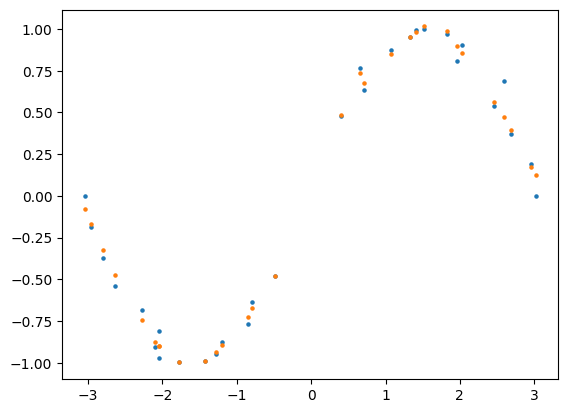

In [7]:
y_pred = model.predict(x)

plt.scatter(x, y, s=5)
plt.scatter(x, y_pred, s=5)

#### Testing our model

We can now test our model. We randomly sample a set of `m` points and proceed to test the effectiveness of our model.

In [8]:
x_test = np.linspace(-3.14, 3.14, 1000)
y_test_true = np.sin(x_test)

In [9]:
y_test_pred = model.predict(x_test)

32/32 [==============================] - 0s 1ms/step


In [10]:
keras.losses.MeanSquaredError()(y_test_pred, y_test_true)

<tf.Tensor: shape=(), dtype=float64, numpy=0.9947768025967701>

In [11]:
def plot_prediction(x, y_true, y_pred, x_max, x_min_pos):
  plt.scatter(x, y_true, s=5)
  plt.scatter(x, y_pred, s=5)
  yline = (
      min(y_true.min().item(), y_pred.min().item()),
      max(y_true.max().item(), y_pred.max().item())
  )
  plt.vlines((-x_max, -x_min_pos, x_min_pos, x_max), ymin=yline[0], ymax=yline[1], colors="black")
  x1 = np.array((-x_max, -x_min_pos))
  x2 = np.array((x_min_pos, x_max))
  y1 = np.array([yline[1], yline[1]])
  y2 = np.array([yline[0], yline[0]])
  plt.fill_between(x1, y1, y2, where=(y1 > y2), color="yellow", alpha=.3)
  plt.fill_between(x2, y1, y2, where=(y1 > y2), color="yellow", alpha=.3)

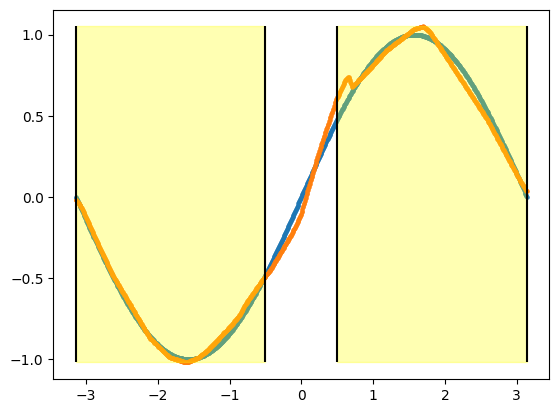

In [12]:
plot_prediction(x_test, y_test_true, y_test_pred, x_max, x_min_pos)

**Q: _comment on this chart? Do you know why are those rough edges present?_**

#### Testing outside of the range $[-\pi,\pi]$

In [13]:
x_test_out = np.concatenate([np.linspace(-7, -x_max, 1000), np.linspace(x_max, 7, 1000)])
y_test_out_true = np.sin(x_test_out)
y_test_out_pred = model.predict(x_test_out)

63/63 [==============================] - 0s 2ms/step


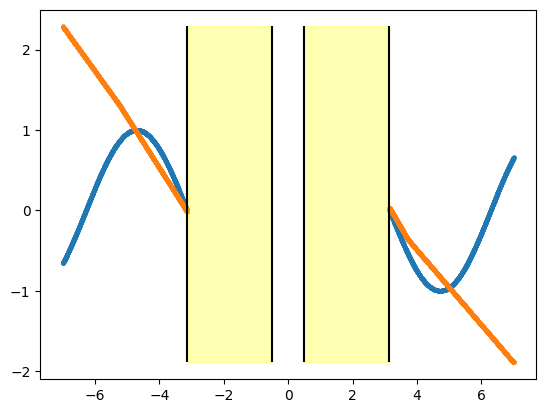

In [14]:
plot_prediction(x_test_out, y_test_out_true, y_test_out_pred, x_max, x_min_pos)

**Q: _why are the predictions so seemingly random outside of the range $[-\pi, \pi]$?_**

#### Combining everything



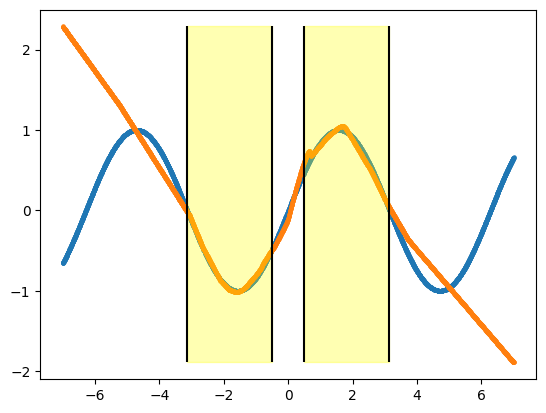

In [15]:
x_test_all = np.concatenate([x_test, x_test_out])
y_test_all_true = np.concatenate([y_test_true, y_test_out_true])
y_test_all_pred = np.concatenate([y_test_pred, y_test_out_pred])
plot_prediction(x_test_all, y_test_all_true, y_test_all_pred, x_max, x_min_pos)

### What about the uncertainty

**Q**: Can we get any information on the uncertainty for this model?

Unfortunately, no, this model only outputs a scalar value, hence we have no information on uncertainty.

We would like to have a way to identify whether the orange predictions are certain/uncertain (i.e., which is the variance of the predictions).
This is only possible with the UE methods we will see later.

#### What about classification NNs?

Let's review how to build and train a model on MNIST...

In [16]:
model_mnist = keras.Sequential([
    keras.layers.Input((28, 28, 1)), # data as image: heigth x width x channels. MNIST is grayscale » 1 channel
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(10),
    keras.layers.Activation("softmax")
])

model_mnist.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]) # notice the different loss function & metric

model_mnist.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 32)                25120     
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Download and preprocess the data...

In [17]:
(x, y), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

def preprocess_data(data):
  '''
  Changes data type to float32, normalizes in [0,1] range, and add a channel singleton dimension
  '''
  return np.expand_dims(data.astype("float32"), -1) / 255

x = preprocess_data(x)
x_test = preprocess_data(x_test)

y = keras.utils.to_categorical(y, 10)
y_test = keras.utils.to_categorical(y_test, 10)

11490434/11490434 [==============================] - 1s 0us/step


Train the model

In [18]:
model_mnist.fit(x, y, batch_size=128, epochs=15)

Epoch 1/15
469/469 [==============================] - 3s 5ms/step - loss: 0.5062 - accuracy: 0.8628
Epoch 2/15
469/469 [==============================] - 2s 5ms/step - loss: 0.2043 - accuracy: 0.9411
Epoch 3/15
469/469 [==============================] - 2s 5ms/step - loss: 0.1623 - accuracy: 0.9532
Epoch 4/15
469/469 [==============================] - 2s 5ms/step - loss: 0.1388 - accuracy: 0.9598
Epoch 5/15
469/469 [==============================] - 2s 5ms/step - loss: 0.1217 - accuracy: 0.9651
Epoch 6/15
469/469 [==============================] - 2s 4ms/step - loss: 0.1090 - accuracy: 0.9674
Epoch 7/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0989 - accuracy: 0.9705
Epoch 8/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0895 - accuracy: 0.9735
Epoch 9/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0828 - accuracy: 0.9746
Epoch 10/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0755 - accuracy: 0.9772

Testing...

In [19]:
predictions = model_mnist.predict(x_test)

313/313 [==============================] - 1s 2ms/step


We want to calculate accuracy. How are predictions and ground truth encoded?

In [20]:
print(predictions, "\n")

print(y_test)

[[2.1024361e-08 2.2385652e-08 7.2881092e-05 ... 9.9162734e-01
  1.6188130e-07 1.4871705e-05]
 [6.2289807e-08 2.0709340e-05 9.9962115e-01 ... 1.3016790e-12
  1.5264766e-07 1.0081735e-13]
 [8.7424842e-06 9.9809808e-01 3.7885766e-04 ... 4.5186732e-04
  4.2719115e-04 2.8898801e-06]
 ...
 [1.8422929e-14 1.4709405e-10 5.1627752e-12 ... 2.1181999e-07
  7.5084856e-08 9.4218616e-05]
 [3.7138705e-11 4.0948944e-10 2.0725957e-11 ... 1.7471707e-09
  5.0810524e-08 1.7798185e-11]
 [6.5860928e-11 7.4778312e-17 1.7729931e-13 ... 2.4038092e-18
  1.4462437e-10 1.5057554e-14]] 

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


To use accuracy, we need to convert the predictions and accuracy to labels.
We can do it by assigning each prediction to the index of the maximum value.

This is done using `argmax`

In [21]:
pred_labels = predictions.argmax(axis=1)
test_labels = y_test.argmax(axis=1)

metric = keras.metrics.Accuracy()
metric.update_state(pred_labels, test_labels)
metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.967>

Let's roll back to the predictions. Can we actually get an idea on uncertainty?

In [22]:
predictions[0]

array([2.1024361e-08, 2.2385652e-08, 7.2881092e-05, 8.2846088e-03,
       9.3693175e-10, 1.1052409e-07, 4.4550477e-14, 9.9162734e-01,
       1.6188130e-07, 1.4871705e-05], dtype=float32)

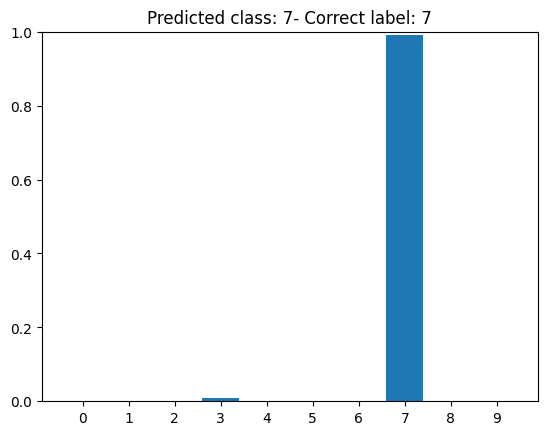

In [23]:
def plot_predictions(prediction, label=None):
  _=plt.bar(x=np.arange(0,10), height=prediction.squeeze())
  _=plt.xticks(np.arange(0,10))
  class_prediction = prediction.argmax()
  plt.ylim((0,1))

  title = f"Predicted class: {class_prediction}"
  if label is not None:
    title += f"- Correct label: {label}"

  _ = plt.title(title)

  plt.show()

plot_predictions(predictions[0], label=test_labels[0])

This vector can be interpreted as a probability distribution.

We can interpret the confidence of the model as the $\max$ of this vector.

Let's see an example in which the model is misclassifying the data.

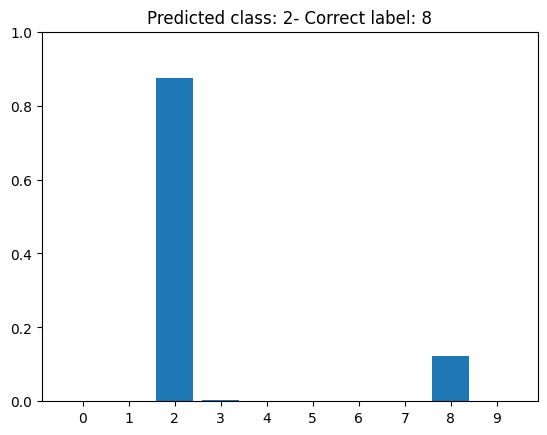

In [24]:
misclassifications = pred_labels != test_labels
index = misclassifications.nonzero()[0][0]


plot_predictions(
    predictions[index],
    label=test_labels[index]
  )

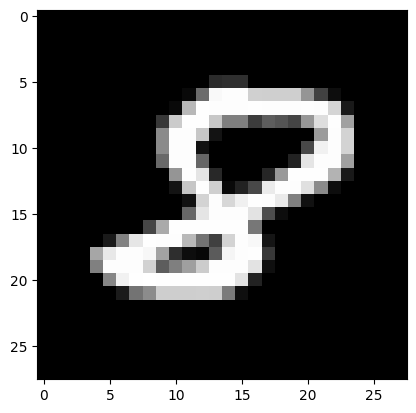

In [25]:
plt.imshow(x_test[index], cmap="gray")

**Q**: *How high is the confidence in this case?*


Deep Neural Networks can easily classify very confidently random images, as noticed in the paper [**Deep neural networks are easily fooled: High confidence predictions for unrecognizable images**](https://ieeexplore.ieee.org/document/7298640) by Nguyen et al., 2015.

![](https://www.researchgate.net/profile/Anh-Nguyen-282/publication/307560165/figure/fig1/AS:476566221266944@1490633649679/Evolved-images-that-are-unrecognizable-to-humans-but-that-state-of-the-art-DNNs-trained.png)

The image above, which is part of the same paper, the authors show how completely random images can be classified by the models employed as existing categories with confidence > 99%.

This introductory notebook was just a preview of things to come. Let's start working with BNNs next!